Loading the dataset...

Preprocessing the data...

Performing feature engineering...
Original training set shape: default payment next month
0    18691
1     5309
Name: count, dtype: int64
Resampled training set shape: default payment next month
0    18691
1     5309
Name: count, dtype: int64

Training models...
Best Logistic Regression Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

Evaluating models...

Logistic Regression Performance:
Accuracy: 0.8046666666666666
Precision: 0.6179604261796042
Recall: 0.3059532780708365
F1-Score: 0.4092741935483871
AUC-ROC: 0.7482875135601575
Confusion Matrix:
 [[4422  251]
 [ 921  406]]

Random Forest Performance:
Accuracy: 0.8175
Precision: 0.657608695652174
Recall: 0.36473247927656366
F1-Score: 0.4692195831313621
AUC-ROC: 0.7748801779563562
Confusion Matrix:
 [[4421  252]
 [ 843  484]]

Analyzing feature importance for Random Forest...


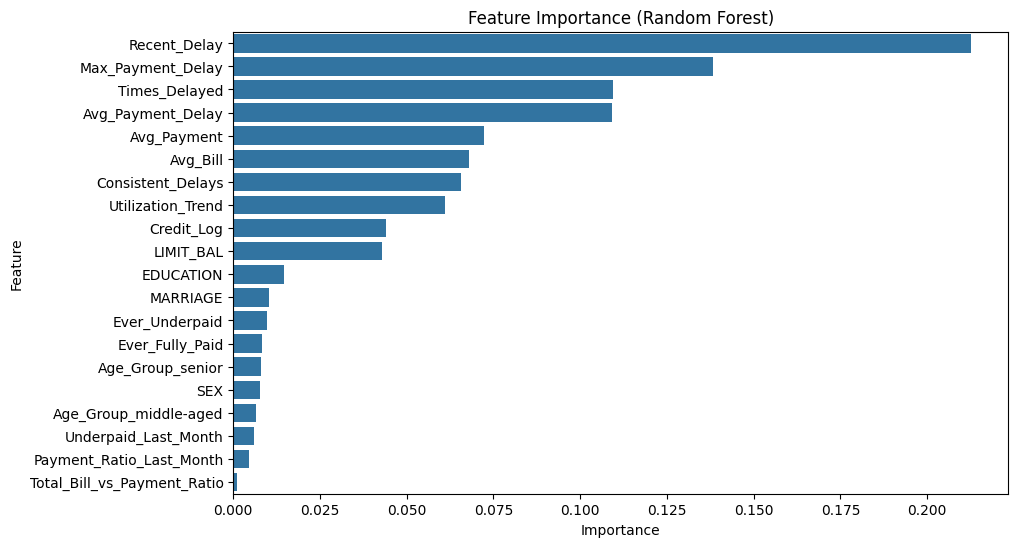


Conclusion:
- Achievements: Built a predictive model with advanced feature engineering, reduced dimensionality, handled imbalance using SMOTE, and evaluated performance with appropriate metrics.
- Next Steps:
  - Experiment with advanced models like XGBoost.
  - Implement a K-S chart for probability calibration.
  - Deploy the Random Forest model for risk assessment, with Logistic Regression as a fallback for interpretability.


In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# 1. Load and Inspect the Data
print("Loading the dataset...")
df = pd.read_excel('data.xls', header=1)

# 2. Data Preprocessing
print("\nPreprocessing the data...")
# Drop unnecessary column
df = df.drop('ID', axis=1)

# 3. Feature Engineering (Combined from Recommendations)
print("\nPerforming feature engineering...")

# 3.1 Payment Behavior Features (from PAY_0 to PAY_6)
payment_status_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
df['Avg_Payment_Delay'] = df[payment_status_cols].replace(-1, 0).mean(axis=1)
df['Max_Payment_Delay'] = df[payment_status_cols].max(axis=1)
df['Times_Delayed'] = (df[payment_status_cols] > 0).sum(axis=1)

# Calculate consecutive delays
df['Consistent_Delays'] = 0
for i in range(len(payment_status_cols) - 1):
    df['Consistent_Delays'] += ((df[payment_status_cols[i]] > 0) & (df[payment_status_cols[i+1]] > 0)).astype(int)

df['Recent_Delay'] = df['PAY_0']

# 3.2 Payment vs. Bill Behavior (from BILL_AMT1 to BILL_AMT6, PAY_AMT1 to PAY_AMT6)
bill_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
payment_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

df['Avg_Bill'] = df[bill_cols].mean(axis=1)
df['Avg_Payment'] = df[payment_cols].mean(axis=1)
df['Payment_Ratio_Last_Month'] = df['PAY_AMT1'] / (df['BILL_AMT1'] + 1e-6)
df['Total_Bill_vs_Payment_Ratio'] = df[payment_cols].sum(axis=1) / (df[bill_cols].sum(axis=1) + 1e-6)

# Utilization trend (slope of bill amounts)
bill_series = df[bill_cols].values
df['Utilization_Trend'] = [np.polyfit(range(6), bill_series[i], 1)[0] for i in range(len(df))]

# 3.3 Binary Flags
df['Underpaid_Last_Month'] = (df['PAY_AMT1'] < df['BILL_AMT1']).astype(int)

# Ever fully paid
df['Ever_Fully_Paid'] = 0
for pay_col, bill_col in zip(payment_cols, bill_cols):
    df['Ever_Fully_Paid'] = df['Ever_Fully_Paid'] | (df[pay_col] >= df[bill_col])
df['Ever_Fully_Paid'] = df['Ever_Fully_Paid'].astype(int)

# Ever underpaid
df['Ever_Underpaid'] = 0
for pay_col, bill_col in zip(payment_cols, bill_cols):
    df['Ever_Underpaid'] = df['Ever_Underpaid'] | (df[pay_col] < df[bill_col])
df['Ever_Underpaid'] = df['Ever_Underpaid'].astype(int)

# 3.4 Basic Variable Transformations
df['Credit_Log'] = np.log(df['LIMIT_BAL'] + 1)

# Bin age into groups
bins = [0, 30, 50, float('inf')]
labels = ['young', 'middle-aged', 'senior']
df['Age_Group'] = pd.cut(df['AGE'], bins=bins, labels=labels, include_lowest=True)

# # Combine Education and Marital Status into Demographic_Code
# df['Demographic_Code'] = df['EDUCATION'].astype(str) + '_' + df['MARRIAGE'].astype(str)

# # 3.5 Additional Feature Engineering on Demographics
# # Age and Credit interaction
# df['Age_Credit_Interaction'] = df['AGE'] * df['LIMIT_BAL']

# # Gender and Education interaction
# df['Gender_Education_Interaction'] = df['SEX'].astype(str) + '_' + df['EDUCATION'].astype(str)

# 3.6 Drop Original Columns
columns_to_drop = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',  # Payment status
                   'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',  # Bill amounts
                   'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',  # Payment amounts
                    'AGE']  # Demographic columns
df = df.drop(columns=columns_to_drop)

# 3.7 Encode Categorical Features
df = pd.get_dummies(df, columns=['Age_Group'], drop_first=True)

# 4. Split Features and Target
X = df.drop('default payment next month', axis=1)
y = df['default payment next month']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 5. Scale Numerical Features
scaler = StandardScaler()
numerical_cols = ['LIMIT_BAL', 'Avg_Payment_Delay', 'Max_Payment_Delay', 'Times_Delayed', 'Consistent_Delays',
                  'Recent_Delay', 'Avg_Bill', 'Avg_Payment', 'Payment_Ratio_Last_Month',
                  'Total_Bill_vs_Payment_Ratio', 'Utilization_Trend', 'Credit_Log']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# # 6. Handle Imbalanced Data with SMOTE
# print("\nHandling imbalanced data using SMOTE...")
# smote = SMOTE(random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
X_train_res=X_train
y_train_res = y_train
print('Original training set shape:', y_train.value_counts())
print('Resampled training set shape:', pd.Series(y_train_res).value_counts())

# 7. Model Training
print("\nTraining models...")
# Logistic Regression with GridSearchCV
log_reg = LogisticRegression(max_iter=1000)
param_grid_lr = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid_lr = GridSearchCV(log_reg, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)
grid_lr.fit(X_train_res, y_train_res)

print('Best Logistic Regression Parameters:', grid_lr.best_params_)
best_lr = grid_lr.best_estimator_

# Random Forest with GridSearchCV
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train_res, y_train_res)

print('Best Random Forest Parameters:', grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

# 8. Model Evaluation
print("\nEvaluating models...")
# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(f'\n{model_name} Performance:')
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1-Score:', f1_score(y_test, y_pred))
    print('AUC-ROC:', roc_auc_score(y_test, y_prob))
    print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

# Evaluate both models
evaluate_model(best_lr, X_test, y_test, 'Logistic Regression')
evaluate_model(best_rf, X_test, y_test, 'Random Forest')

# 9. Feature Importance (Random Forest)
print("\nAnalyzing feature importance for Random Forest...")
importances = best_rf.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance (Random Forest)')
plt.show()

# 10. Conclusion
print("\nConclusion:")
print("- Achievements: Built a predictive model with advanced feature engineering, reduced dimensionality, handled imbalance using SMOTE, and evaluated performance with appropriate metrics.")
print("- Next Steps:")
print("  - Experiment with advanced models like XGBoost.")
print("  - Implement a K-S chart for probability calibration.")
print("  - Deploy the Random Forest model for risk assessment, with Logistic Regression as a fallback for interpretability.")

Loading the dataset...

Preprocessing the data...

Performing feature engineering...

Training models...
Best Logistic Regression Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

Evaluating models with threshold tuning...

Logistic Regression Optimal Threshold: 0.617

Logistic Regression Performance (Default Threshold = 0.5):
Accuracy: 0.7396666666666667
Precision: 0.43603701687534024
Recall: 0.6036171816126601
F1-Score: 0.5063211125158028
AUC-ROC: 0.7508928699574637
Confusion Matrix:
 [[3637 1036]
 [ 526  801]]

Logistic Regression Performance (Optimal Threshold = 0.617):
Accuracy: 0.7871666666666667
Precision: 0.5188253012048193
Recall: 0.519216277317257
F1-Score: 0.5190207156308851
AUC-ROC: 0.7508928699574637
Confusion Matrix:
 [[4034  639]
 [ 638  689]]

Random Forest Optimal Threshold: 0.563

Random Forest Performance (Default Threshold = 0.5):
Accuracy: 0.7736666666666666
Pr

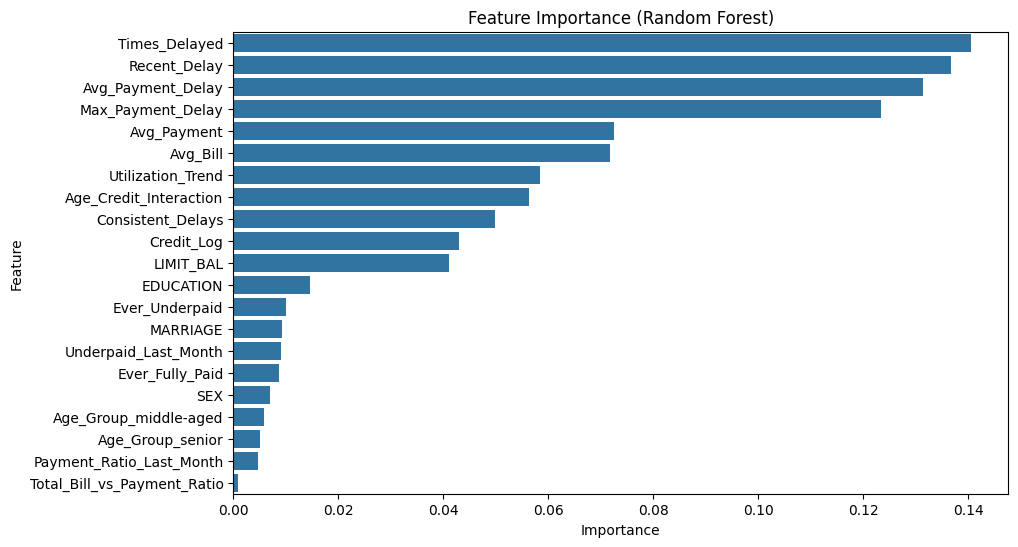


Conclusion:
- Achievements: Improved recall by using class weights, threshold tuning, and targeted feature engineering without SMOTE.
- Next Steps:
  - Experiment with other models like XGBoost with similar class weighting.
  - Implement a K-S chart for probability calibration.
  - Deploy the Random Forest model with the optimal threshold for risk assessment.


In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# 1. Load and Inspect the Data
print("Loading the dataset...")
df = pd.read_excel('data.xls', header=1)

# 2. Data Preprocessing
print("\nPreprocessing the data...")
# Drop unnecessary column
df = df.drop('ID', axis=1)

# 3. Feature Engineering
print("\nPerforming feature engineering...")

# 3.1 Payment Behavior Features (from PAY_0 to PAY_6)
payment_status_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
df['Avg_Payment_Delay'] = df[payment_status_cols].replace(-1, 0).mean(axis=1)
df['Max_Payment_Delay'] = df[payment_status_cols].max(axis=1)
df['Times_Delayed'] = (df[payment_status_cols] > 0).sum(axis=1)

# Calculate consecutive delays
df['Consistent_Delays'] = 0
for i in range(len(payment_status_cols) - 1):
    df['Consistent_Delays'] += ((df[payment_status_cols[i]] > 0) & (df[payment_status_cols[i+1]] > 0)).astype(int)

df['Recent_Delay'] = df['PAY_0']

# 3.2 Payment vs. Bill Behavior (from BILL_AMT1 to BILL_AMT6, PAY_AMT1 to PAY_AMT6)
bill_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
payment_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

df['Avg_Bill'] = df[bill_cols].mean(axis=1)
df['Avg_Payment'] = df[payment_cols].mean(axis=1)
df['Payment_Ratio_Last_Month'] = df['PAY_AMT1'] / (df['BILL_AMT1'] + 1e-6)
df['Total_Bill_vs_Payment_Ratio'] = df[payment_cols].sum(axis=1) / (df[bill_cols].sum(axis=1) + 1e-6)

# Utilization trend (slope of bill amounts)
bill_series = df[bill_cols].values
df['Utilization_Trend'] = [np.polyfit(range(6), bill_series[i], 1)[0] for i in range(len(df))]

# 3.3 Binary Flags
df['Underpaid_Last_Month'] = (df['PAY_AMT1'] < df['BILL_AMT1']).astype(int)

# Ever fully paid
df['Ever_Fully_Paid'] = 0
for pay_col, bill_col in zip(payment_cols, bill_cols):
    df['Ever_Fully_Paid'] = df['Ever_Fully_Paid'] | (df[pay_col] >= df[bill_col])
df['Ever_Fully_Paid'] = df['Ever_Fully_Paid'].astype(int)

# Ever underpaid
df['Ever_Underpaid'] = 0
for pay_col, bill_col in zip(payment_cols, bill_cols):
    df['Ever_Underpaid'] = df['Ever_Underpaid'] | (df[pay_col] < df[bill_col])
df['Ever_Underpaid'] = df['Ever_Underpaid'].astype(int)

# 3.4 Basic Variable Transformations
df['Credit_Log'] = np.log(df['LIMIT_BAL'] + 1)

# Bin age into groups
bins = [0, 30, 50, float('inf')]
labels = ['young', 'middle-aged', 'senior']
df['Age_Group'] = pd.cut(df['AGE'], bins=bins, labels=labels, include_lowest=True)

# 3.5 Additional Feature Engineering on Demographics
# Age and Credit interaction
df['Age_Credit_Interaction'] = df['AGE'] * df['LIMIT_BAL']

# 3.6 Drop Original Columns
columns_to_drop = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',  # Payment status
                   'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',  # Bill amounts
                   'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',  # Payment amounts
                   'AGE']  # Drop AGE since Age_Group and Age_Credit_Interaction capture its information
df = df.drop(columns=columns_to_drop)

# 3.7 Encode Categorical Features
df = pd.get_dummies(df, columns=['Age_Group'], drop_first=True)

# 4. Split Features and Target
X = df.drop('default payment next month', axis=1)
y = df['default payment next month']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 5. Scale Numerical Features
scaler = StandardScaler()
numerical_cols = ['LIMIT_BAL', 'Avg_Payment_Delay', 'Max_Payment_Delay', 'Times_Delayed', 'Consistent_Delays',
                  'Recent_Delay', 'Avg_Bill', 'Avg_Payment', 'Payment_Ratio_Last_Month',
                  'Total_Bill_vs_Payment_Ratio', 'Utilization_Trend', 'Credit_Log', 'Age_Credit_Interaction']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# 6. Model Training with Class Weights to Improve Recall
print("\nTraining models...")

# Compute class weights
class_weights = {0: 1.0, 1: len(y_train[y_train == 0]) / len(y_train[y_train == 1])}  # Higher weight for minority class

# Logistic Regression with GridSearchCV
log_reg = LogisticRegression(max_iter=1000, class_weight=class_weights)
param_grid_lr = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid_lr = GridSearchCV(log_reg, param_grid_lr, cv=5, scoring='recall', n_jobs=-1)  # Optimize for recall
grid_lr.fit(X_train, y_train)

print('Best Logistic Regression Parameters:', grid_lr.best_params_)
best_lr = grid_lr.best_estimator_

# Random Forest with GridSearchCV
rf = RandomForestClassifier(random_state=42, class_weight=class_weights)
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='recall', n_jobs=-1)  # Optimize for recall
grid_rf.fit(X_train, y_train)

print('Best Random Forest Parameters:', grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

# 7. Model Evaluation with Threshold Tuning
print("\nEvaluating models with threshold tuning...")

# Function to evaluate models with adjustable threshold
def evaluate_model_with_threshold(model, X_test, y_test, model_name, default_threshold=0.5):
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Use precision-recall curve to find optimal threshold for recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    # Find threshold that maximizes recall while keeping precision reasonable
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
    optimal_idx = np.argmax(f1_scores)  # Maximize F1-score as a balance
    optimal_threshold = thresholds[optimal_idx]
    print(f"\n{model_name} Optimal Threshold: {optimal_threshold:.3f}")
    
    # Evaluate with default threshold (0.5)
    y_pred_default = (y_prob >= default_threshold).astype(int)
    print(f"\n{model_name} Performance (Default Threshold = {default_threshold}):")
    print('Accuracy:', accuracy_score(y_test, y_pred_default))
    print('Precision:', precision_score(y_test, y_pred_default))
    print('Recall:', recall_score(y_test, y_pred_default))
    print('F1-Score:', f1_score(y_test, y_pred_default))
    print('AUC-ROC:', roc_auc_score(y_test, y_prob))
    print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_default))
    
    # Evaluate with optimal threshold
    y_pred_optimal = (y_prob >= optimal_threshold).astype(int)
    print(f"\n{model_name} Performance (Optimal Threshold = {optimal_threshold:.3f}):")
    print('Accuracy:', accuracy_score(y_test, y_pred_optimal))
    print('Precision:', precision_score(y_test, y_pred_optimal))
    print('Recall:', recall_score(y_test, y_pred_optimal))
    print('F1-Score:', f1_score(y_test, y_pred_optimal))
    print('AUC-ROC:', roc_auc_score(y_test, y_prob))
    print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_optimal))

# Evaluate both models
evaluate_model_with_threshold(best_lr, X_test, y_test, 'Logistic Regression')
evaluate_model_with_threshold(best_rf, X_test, y_test, 'Random Forest')

# 8. Feature Importance (Random Forest)
print("\nAnalyzing feature importance for Random Forest...")
importances = best_rf.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance (Random Forest)')
plt.show()

# 9. Conclusion
print("\nConclusion:")
print("- Achievements: Improved recall by using class weights, threshold tuning, and targeted feature engineering without SMOTE.")
print("- Next Steps:")
print("  - Experiment with other models like XGBoost with similar class weighting.")
print("  - Implement a K-S chart for probability calibration.")
print("  - Deploy the Random Forest model with the optimal threshold for risk assessment.")

In [3]:
pip install imblearn

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\josep\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
